# Expore data

In [1]:
import os
import sys
import re
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json

# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definition
PAST_HISTORY = 48 # days used to predict next values in future
FUTURE_TARGET = 12 # nb predict days later
STEP = 1

path_save_df_feat = "data/path_save_df_feat.csv"

## Load raw features

In [2]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw



,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date
0,1609459200000,736.42,739.00,729.33,734.07,27932.69884,2021-01-01 00:00:00,2324.747451,2317.021738,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
1,1609462800000,734.08,749.00,733.37,748.28,52336.18779,2021-01-01 01:00:00,2324.747451,2317.021738,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
2,1609466400000,748.27,749.00,742.27,744.06,33019.50100,2021-01-01 02:00:00,2324.747451,2317.021738,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
3,1609470000000,744.06,747.23,743.10,744.82,17604.80859,2021-01-01 03:00:00,2324.747451,2317.021738,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
4,1609473600000,744.87,747.09,739.30,742.29,18794.15424,2021-01-01 04:00:00,2324.747451,2317.021738,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18643,1676574000000,1716.68,1718.19,1706.83,1710.85,15820.92910,2023-02-16 19:00:00,1566.897500,1527.800000,1660.235,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
18644,1676577600000,1710.85,1711.11,1680.00,1685.00,48306.90610,2023-02-16 20:00:00,1570.302500,1529.095000,1665.695,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
18645,1676581200000,1684.99,1685.00,1667.54,1683.09,29334.82390,2023-02-16 21:00:00,1588.770000,1545.625000,1683.610,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
18646,1676584800000,1683.09,1684.89,1641.40,1646.09,43934.43760,2023-02-16 22:00:00,1617.352500,1571.110000,1692.185,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN


In [3]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_BTC            1
vwap_z_score_ETH            1
ichi_tenkan_BTC             8
ichi_tenkan_ETH             8
rsi_h_BTC                  13
min_low_h_ETH              13
min_low_h_BTC              13
chop_h_BTC                 13
rsi_h_ETH                  13
max_high_h_ETH             13
max_high_h_BTC             13
chop_h_ETH                 13
ichi_cloud_a_BTC           25
ichi_kijun_ETH             25
ichi_kijun_BTC             25
ichi_cloud_a_ETH           25
ichi_tenkan_day_BTC       215
ichi_tenkan_day_ETH       215
rsi_d_ETH                 335
min_low_d_BTC             335
max_high_d_BTC            335
rsi_d_BTC                 335
max_high_d_ETH            335
min_low_d_ETH             335
chop_d_ETH                335
chop_d_BTC                335
ichi_cloud_a_day_ETH      623
ichi_cloud_a_day_BTC      623
ichi_kijun_day_ETH        623
ichi_kijun_day_BTC        623
dxy                      1109
fvx                      1117
spx                     

<AxesSubplot: >

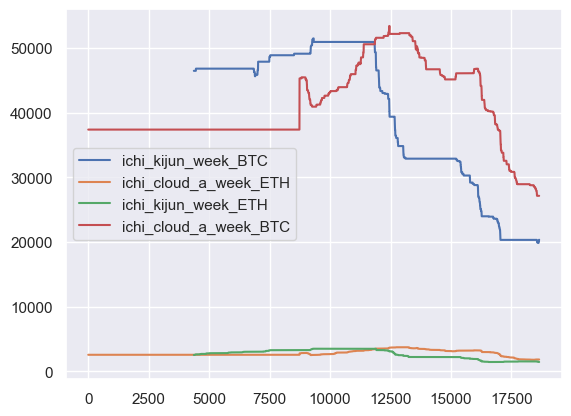

In [4]:
df_feat_raw[["ichi_kijun_week_BTC"   ,    
"ichi_cloud_a_week_ETH"   ,  
"ichi_kijun_week_ETH"    ,   
"ichi_cloud_a_week_BTC"]].plot()

### drop nan

In [5]:
print(df_feat_raw.shape)
df_feat = df_feat_raw.dropna(subset=["ichi_kijun_week_ETH"]).copy()
df_feat.reset_index(inplace=True)
df_feat.shape

(18648, 135)


(14281, 136)

In [6]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       14210
delta_event_real    14210
delta_event_pred    14210
Previous_num        14210
Actual_num          14210
Event               14210
Date                14210
Previous            14210
Consensus           14210
Actual              14210
Country             14210
Time (ET)           14210
keep                14210
date                14210
dtype: int64

on 14281 samples


## Features Selection

### Propotional to the Price

In [7]:
list_col = df_feat.columns.to_list()
list_col

['index',
 'Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ra

In [8]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [9]:
df_feat[list_col_ETH]

,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,...,vwap_m_ETH,vwap_3m_ETH,vwap_6m_ETH,vwap_y_ETH,vwap_all_ETH,vwap_z_score_ETH,nupl_ETH,supply_ETH,act_addr_ETH,market_dom_ETH
0,2128.88,2135.07,2104.88,2106.41,20782.46239,2021-07-01 23:00:00,2188.2400,2174.775,2177.520,2107.755,...,1997.853156,1997.853156,1997.853156,1997.853156,1997.853156,0.155010,0.051536,1.166930e+08,527404.0,17.768278
1,2106.41,2136.00,2096.00,2135.18,22888.95033,2021-07-02 00:00:00,2188.2400,2174.775,2177.520,2107.755,...,1997.866014,1997.866014,1997.866014,1997.866014,1997.866014,0.196095,0.064310,1.167075e+08,501748.0,17.533440
2,2135.50,2139.00,2084.04,2087.34,28744.05686,2021-07-02 01:00:00,2188.2400,2174.775,2174.525,2107.755,...,1997.879702,1997.879702,1997.879702,1997.879702,1997.879702,0.127771,0.042859,1.167075e+08,501748.0,17.533440
3,2087.45,2103.64,2082.00,2094.46,18099.07919,2021-07-02 02:00:00,2189.4400,2174.775,2170.405,2107.755,...,1997.887496,1997.887496,1997.887496,1997.887496,1997.887496,0.137944,0.046109,1.167075e+08,501748.0,17.533440
4,2094.45,2095.74,2033.96,2041.20,47236.16323,2021-07-02 03:00:00,2192.3925,2174.775,2149.315,2086.980,...,1997.900078,1997.900078,1997.900078,1997.900078,1997.900078,0.061857,0.021213,1.167075e+08,501748.0,17.533440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14276,1716.68,1718.19,1706.83,1710.85,15820.92910,2023-02-16 19:00:00,1566.8975,1527.800,1660.235,1704.105,...,1481.423425,2192.241093,2112.034508,1684.967117,2112.034508,-0.408219,-0.234494,1.204963e+08,434425.0,18.136519
14277,1710.85,1711.11,1680.00,1685.00,48306.90610,2023-02-16 20:00:00,1570.3025,1529.095,1665.695,1704.105,...,1481.436143,2192.149994,2112.000771,1684.877674,2112.000771,-0.434494,-0.253413,1.204963e+08,434425.0,18.136519
14278,1684.99,1685.00,1667.54,1683.09,29334.82390,2023-02-16 21:00:00,1588.7700,1545.625,1683.610,1704.105,...,1481.464607,2192.067967,2111.979628,1684.831222,2111.979628,-0.436423,-0.254823,1.204963e+08,434425.0,18.136519
14279,1683.09,1684.89,1641.40,1646.09,43934.43760,2023-02-16 22:00:00,1617.3525,1571.110,1692.185,1692.185,...,1481.493730,2191.971223,2111.946426,1684.796788,2111.946426,-0.474046,-0.283008,1.204963e+08,434425.0,18.136519


In [10]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [11]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [12]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [13]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [14]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

### Not proportional to the Price 

In [15]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'dxy',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'hour',
 'hour_cos',
 'hour_sin',
 'index',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'spx',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_si

In [16]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    'dxy',
    'spx',
    'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    'month_cos',
    'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [17]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +    
    list_col_other
)


# selection
list_col_select = list_col_select_global
print("num features : ", len(list_col_select))

num features :  104


In [18]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [19]:
df_feat["event_real"].describe()

count    14281.000000
mean        -0.000630
std          0.049503
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: event_real, dtype: float64

In [20]:
df_feat["event_real"].value_counts()

 0.0    14246
-1.0       22
 1.0       13
Name: event_real, dtype: int64

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [21]:
df_feat.shape[0]

14281

In [22]:
TRAIN_SPLIT = round(0.8 * df_feat.shape[0])
TRAIN_SPLIT

11425

In [23]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

,index,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,...,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,train
0,4367,1625180400000,2128.88,2135.07,2104.88,2106.41,20782.46239,2021-07-01 23:00:00,2188.2400,2174.775,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
1,4368,1625184000000,2106.41,2136.00,2096.00,2135.18,22888.95033,2021-07-02 00:00:00,2188.2400,2174.775,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
2,4369,1625187600000,2135.50,2139.00,2084.04,2087.34,28744.05686,2021-07-02 01:00:00,2188.2400,2174.775,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
3,4370,1625191200000,2087.45,2103.64,2082.00,2094.46,18099.07919,2021-07-02 02:00:00,2189.4400,2174.775,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
4,4371,1625194800000,2094.45,2095.74,2033.96,2041.20,47236.16323,2021-07-02 03:00:00,2192.3925,2174.775,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14276,18643,1676574000000,1716.68,1718.19,1706.83,1710.85,15820.92910,2023-02-16 19:00:00,1566.8975,1527.800,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
14277,18644,1676577600000,1710.85,1711.11,1680.00,1685.00,48306.90610,2023-02-16 20:00:00,1570.3025,1529.095,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
14278,18645,1676581200000,1684.99,1685.00,1667.54,1683.09,29334.82390,2023-02-16 21:00:00,1588.7700,1545.625,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
14279,18646,1676584800000,1683.09,1684.89,1641.40,1646.09,43934.43760,2023-02-16 22:00:00,1617.3525,1571.110,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False


In [24]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [25]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [26]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
    ) 
    for col in list_col_select ]

In [27]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(11366, 48, 104) (11366, 12)
(2795, 48, 104) (2795, 12)


In [28]:
seq_y

array([0.99436767, 0.99866117, 1.00499369, 1.00014619, 0.99303653,
       0.98858915, 0.99173617, 0.98839679, 0.9868502 , 0.98859684,
       0.98716568, 0.98686559])

In [29]:
y_train

array([[1.00967057, 1.00048512, 0.99583798, ..., 1.05636408, 1.05341712,
        1.05926571],
       [0.99090252, 0.98629989, 0.99140095, ..., 1.04332754, 1.04912011,
        1.04669082],
       [0.99535512, 1.00050301, 1.00135948, ..., 1.05875209, 1.0563005 ,
        1.0455289 ],
       ...,
       [1.00210599, 1.00257656, 0.99692972, ..., 0.99094345, 0.98939289,
        0.99114403],
       [1.00046958, 0.99483461, 0.99913012, ..., 0.98731361, 0.98906107,
        0.98762923],
       [0.99436767, 0.99866117, 1.00499369, ..., 0.98859684, 0.98716568,
        0.98686559]])

In [30]:
seq_y

array([0.99436767, 0.99866117, 1.00499369, 1.00014619, 0.99303653,
       0.98858915, 0.99173617, 0.98839679, 0.9868502 , 0.98859684,
       0.98716568, 0.98686559])

In [31]:
y_train

array([[1.00967057, 1.00048512, 0.99583798, ..., 1.05636408, 1.05341712,
        1.05926571],
       [0.99090252, 0.98629989, 0.99140095, ..., 1.04332754, 1.04912011,
        1.04669082],
       [0.99535512, 1.00050301, 1.00135948, ..., 1.05875209, 1.0563005 ,
        1.0455289 ],
       ...,
       [1.00210599, 1.00257656, 0.99692972, ..., 0.99094345, 0.98939289,
        0.99114403],
       [1.00046958, 0.99483461, 0.99913012, ..., 0.98731361, 0.98906107,
        0.98762923],
       [0.99436767, 0.99866117, 1.00499369, ..., 0.98859684, 0.98716568,
        0.98686559]])

In [32]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [33]:
X_train.shape

(11366, 48, 104)

In [34]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(11366, 48, 104) (11366, 12)
(2795, 48, 104) (2795, 12)


## Standardization

In [35]:
scaler = StandardScaler()
X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

### Check unscaling

In [36]:
df_feat[list_col_select].head(10)

,Close_ETH,Open_ETH,High_ETH,Low_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,ichi_cloud_a_day_ETH,ichi_cloud_b_day_ETH,...,hour_sin,weekday_cos,weekday_sin,day_in_month_cos,day_in_month_sin,month_cos,month_sin,day_off,event_pred,event_real
0,2106.41,2128.88,2135.07,2104.88,2188.2400,2174.775,2177.520,2107.755,2793.485,3050.73,...,-0.258819,-0.900969,0.433884,0.979530,0.201299,-0.866025,-0.5,0.0,0.0,0.0
1,2135.18,2106.41,2136.00,2096.00,2188.2400,2174.775,2177.520,2107.755,2793.485,3050.73,...,0.000000,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0
2,2087.34,2135.50,2139.00,2084.04,2188.2400,2174.775,2174.525,2107.755,2793.485,3050.73,...,0.258819,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0
3,2094.46,2087.45,2103.64,2082.00,2189.4400,2174.775,2170.405,2107.755,2793.485,3050.73,...,0.500000,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0
4,2041.20,2094.45,2095.74,2033.96,2192.3925,2174.775,2149.315,2086.980,2793.485,3050.73,...,0.707107,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0
5,2054.86,2041.19,2058.85,2035.61,2203.5250,2174.775,2134.385,2086.980,2793.485,3050.73,...,0.866025,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0
6,2032.84,2054.86,2058.77,2023.41,2211.6375,2180.675,2129.110,2081.705,2793.485,3050.73,...,0.965926,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0
7,2034.03,2032.92,2041.86,2018.50,2210.8925,2185.445,2126.655,2078.750,2793.485,3050.73,...,1.000000,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0
8,2061.49,2034.35,2070.00,2028.98,2210.8925,2185.445,2126.655,2078.750,2793.485,3050.73,...,0.965926,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0
9,2060.50,2061.49,2080.46,2051.48,2203.1750,2186.930,2094.295,2078.750,2793.485,3050.73,...,0.866025,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0


In [37]:
df_feat["Close_ETH"].iloc[0:10]

0    2106.41
1    2135.18
2    2087.34
3    2094.46
4    2041.20
5    2054.86
6    2032.84
7    2034.03
8    2061.49
9    2060.50
Name: Close_ETH, dtype: float64

In [38]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [39]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [2106.41 2135.18 2087.34 2094.46 2041.2  2054.86 2032.84 2034.03 2061.49
 2060.5 ]
X_train_raw:      [2106.41 2135.18 2087.34 2094.46 2041.2  2054.86 2032.84 2034.03 2061.49
 2060.5 ]


## Autoencoder

### Model creation

In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Définir les dimensions d'entrée
input_dim = X_train.shape[-1]

# Définir les dimensions réduites
encoding_dim = 12

# Définir l'encodeur
encoder_inputs = keras.Input(shape=(None, input_dim))
encoder = layers.LSTM(16, return_sequences=True)(encoder_inputs)
encoder = layers.LSTM(8, return_sequences=True)(encoder)
encoder_outputs = layers.Dense(encoding_dim)(encoder)
encoder_model = keras.Model(encoder_inputs, encoder_outputs)

# Définir le décodeur
decoder_inputs = keras.Input(shape=(None, encoding_dim))
decoder = layers.LSTM(8, return_sequences=True)(decoder_inputs)
decoder = layers.LSTM(16, return_sequences=True)(decoder)
decoder_outputs = layers.Dense(input_dim)(decoder)
decoder_model = keras.Model(decoder_inputs, decoder_outputs)

# Définir l'autoencodeur complet
autoencoder_inputs = keras.Input(shape=(None, input_dim))
encoded = encoder_model(autoencoder_inputs)
decoded = decoder_model(encoded)
autoencoder = keras.Model(autoencoder_inputs, decoded)


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-02-19 08:03:55.471976: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-19 08:03:55.472111: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [41]:
encoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 16)          7744      
                                                                 
 lstm_1 (LSTM)               (None, None, 8)           800       
                                                                 
 dense (Dense)               (None, None, 12)          108       
                                                                 
Total params: 8,652
Trainable params: 8,652
Non-trainable params: 0
_________________________________________________________________


In [42]:
decoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 12)]        0         
                                                                 
 lstm_2 (LSTM)               (None, None, 8)           672       
                                                                 
 lstm_3 (LSTM)               (None, None, 16)          1600      
                                                                 
 dense_1 (Dense)             (None, None, 104)         1768      
                                                                 
Total params: 4,040
Trainable params: 4,040
Non-trainable params: 0
_________________________________________________________________


### Training

In [43]:
# Compiler l'autoencodeur
autoencoder.compile(optimizer="adam", loss="mse")

# earlystop 
es = EarlyStopping(patience=90, verbose=2, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
# Entraîner l'autoencodeur
autoenc_step_history = autoencoder.fit(
    X_train_sca, X_train_sca, epochs=120, 
    batch_size=32, validation_split=0.05, verbose=1, callbacks=[es])
#autoenc_step_history = autoencoder.fit(X_train, X_train, epochs=, batch_size=32, validation_split=0.1, verbose=1)
# Réduire la dimension des données d'entrée avec l'encodeur
encoded_data = encoder_model.predict(X_test_sca)

Epoch 1/120


2023-02-19 08:03:56.998745: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-19 08:03:59.359815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-19 08:03:59.943961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-19 08:04:00.055721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-19 08:04:00.146282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-19 08:04:00.226398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-19 08:04:00.370494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

338/338 [==============================] - ETA: 0s - loss: 0.6205

2023-02-19 08:04:20.349541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-19 08:04:20.560861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-19 08:04:20.626135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-19 08:04:20.700712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-19 08:04:20.769184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


338/338 [==============================] - 25s 61ms/step - loss: 0.6205 - val_loss: 0.5398
Epoch 2/120
338/338 [==============================] - 19s 56ms/step - loss: 0.4033 - val_loss: 0.5065
Epoch 3/120
338/338 [==============================] - 19s 55ms/step - loss: 0.3264 - val_loss: 0.4794
Epoch 4/120
338/338 [==============================] - 19s 56ms/step - loss: 0.2919 - val_loss: 0.4508
Epoch 5/120
338/338 [==============================] - 19s 55ms/step - loss: 0.2700 - val_loss: 0.4290
Epoch 6/120
338/338 [==============================] - 19s 56ms/step - loss: 0.2544 - val_loss: 0.4447
Epoch 7/120
338/338 [==============================] - 19s 57ms/step - loss: 0.2434 - val_loss: 0.4664
Epoch 8/120
338/338 [==============================] - 19s 55ms/step - loss: 0.2335 - val_loss: 0.4433
Epoch 9/120
338/338 [==============================] - 19s 56ms/step - loss: 0.2250 - val_loss: 0.4262
Epoch 10/120
338/338 [==============================] - 19s 57ms/step - loss: 0.2173 

2023-02-19 08:42:06.241385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-19 08:42:06.377538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 4/88 [>.............................] - ETA: 1s 

2023-02-19 08:42:06.472934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 20ms/step


In [44]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

2023-02-19 08:42:09.425763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-19 08:42:09.774800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-19 08:42:09.870672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-19 08:42:09.969071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  3/356 [..............................] - ETA: 12s 

2023-02-19 08:42:10.068381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


356/356 [==============================] - 14s 36ms/step


(11366, 48, 104)

### Results

In [45]:
def plot_train_history(history, title):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    plt.show()

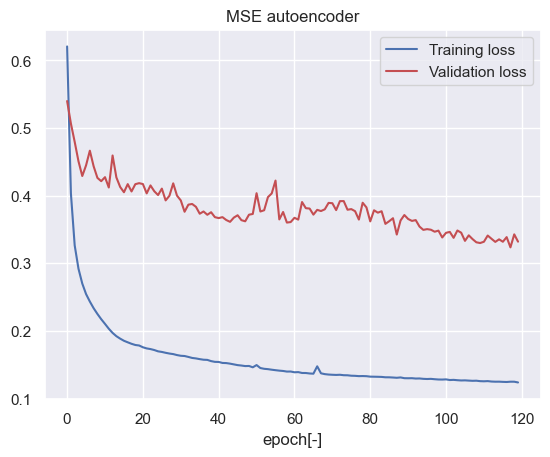

In [46]:
plot_train_history(autoenc_step_history,"MSE autoencoder")

In [47]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

array([0.999062 , 0.9994626, 1.0134671, ..., 1.0084995, 1.0123719,
       1.0092858], dtype=float32)

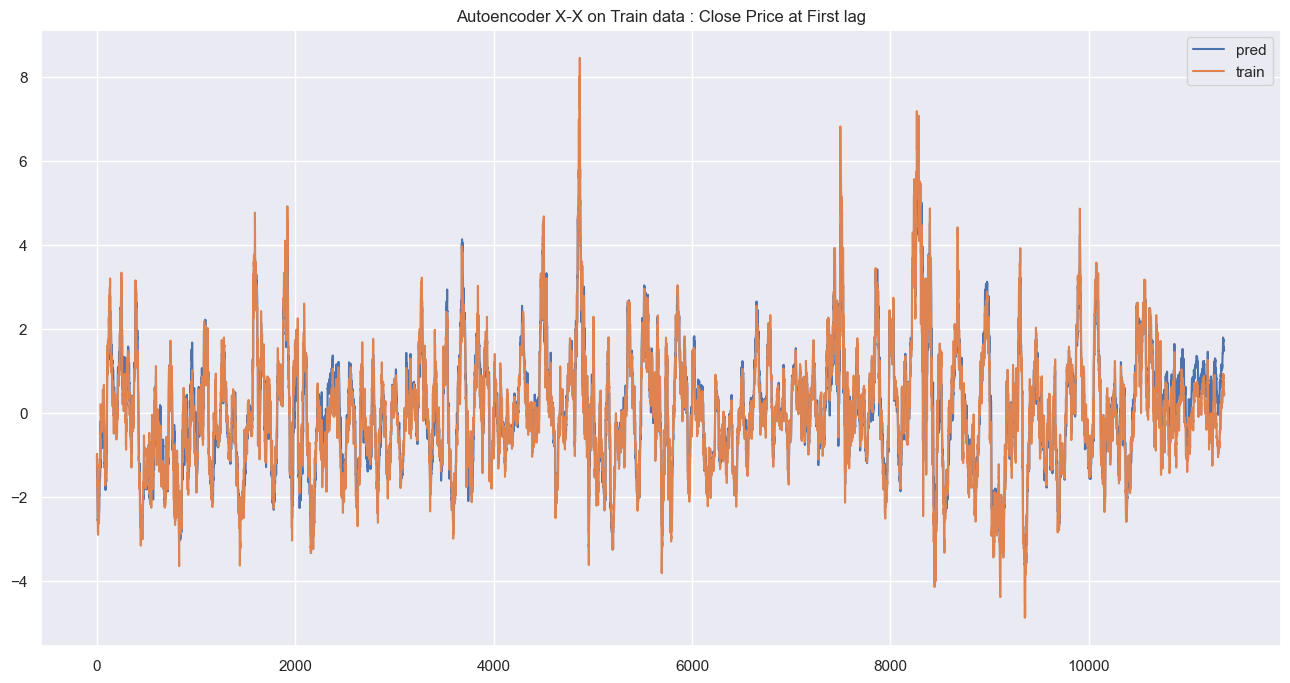

In [79]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

In [80]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(11366,)
(11366,)
[2106.41 2135.18 2087.34 ... 1325.07 1325.89 1331.12]
[2106.41 2135.18 2087.34]


In [ ]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

[2106.41 2135.18 2087.34 ... 1325.07 1325.89 1331.12]
[2111.51987795 2084.63915944 2078.47837664 ... 1387.22372364 1388.49273535
 1388.37040941]


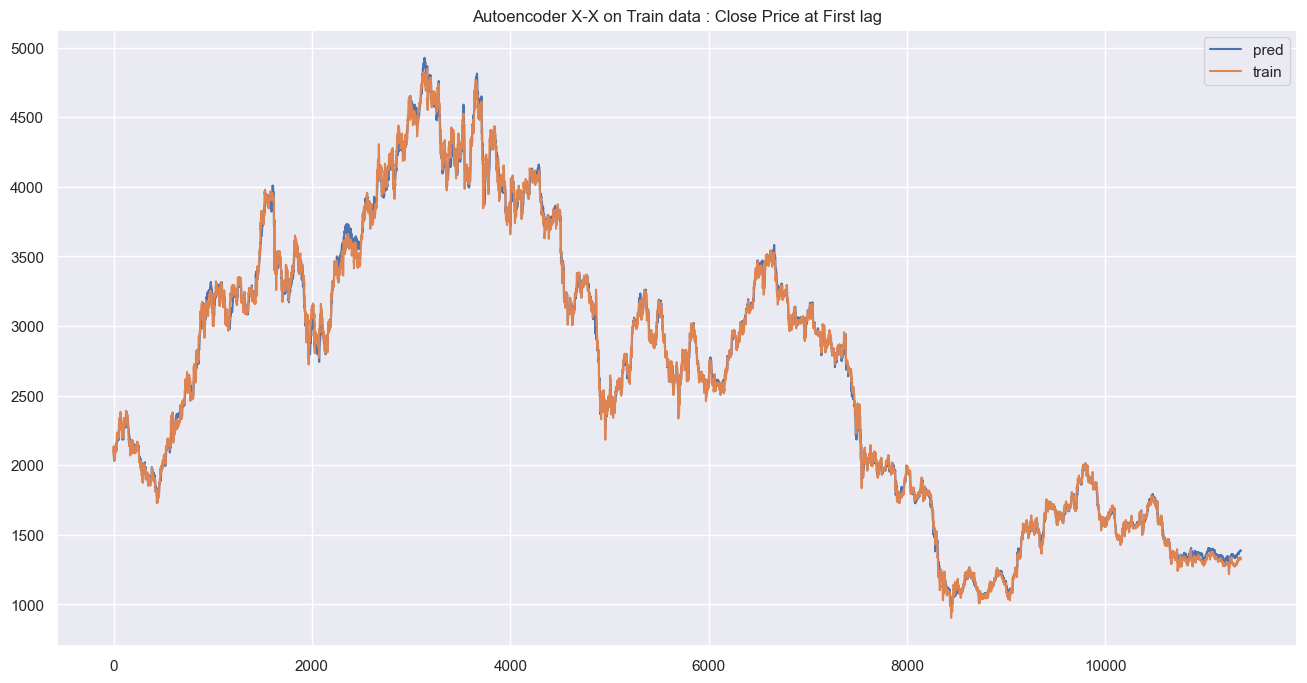

In [82]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### on Test data

In [83]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

88/88 [==============================] - 3s 36ms/step


(2795, 48, 104)

In [84]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2022-10-21 00:00:00'

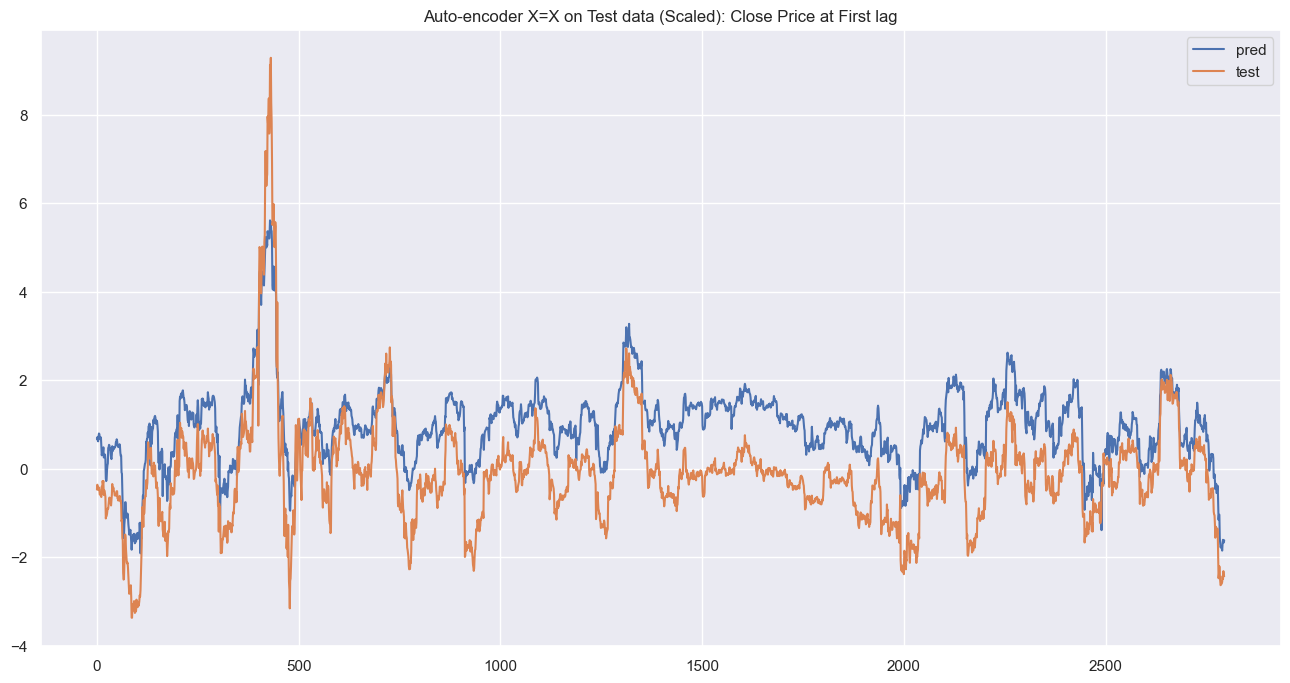

In [85]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [86]:
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
X_test_pred[:,-1,0]

array([0.9971695 , 0.99385154, 0.9961764 , ..., 1.0216403 , 1.024402  ,
       1.017672  ], dtype=float32)

[1286.57 1289.79 1287.54 ... 1511.92 1509.13 1507.7 ]
[1353.57500774 1352.47694161 1352.41045678 ... 1560.39157283 1565.8541202
 1568.65067413]


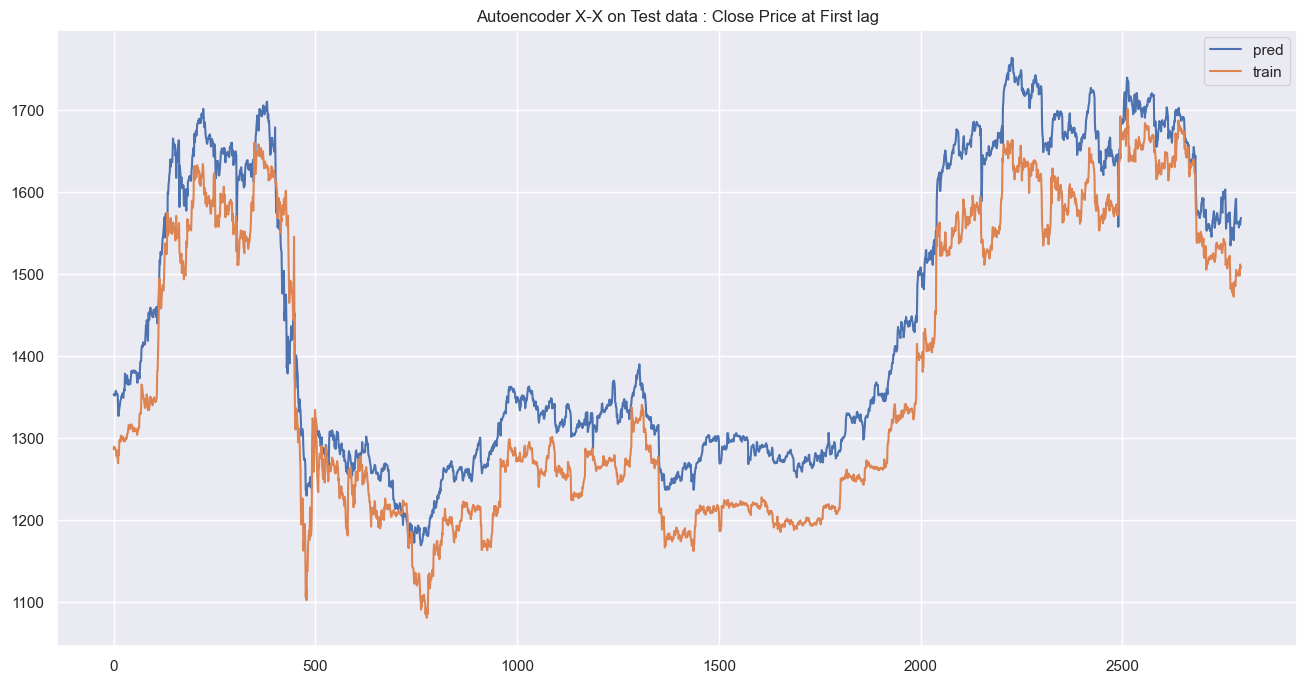

In [87]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [58]:
encoder_model.layers[3].get_weights()

[array([[-0.40232664,  0.7905001 ,  0.19833528, -0.9084196 ,  0.4567641 ,
         -0.03887012, -0.4073284 ,  1.2267696 ,  0.5246545 ,  0.2733904 ,
         -0.599853  , -0.7746502 ],
        [-0.75100803, -0.16856794, -0.08885446,  0.41563326,  0.56275547,
         -0.7560658 , -0.50902736, -0.04096889,  0.08619634, -0.17041862,
         -0.70262223,  1.2704213 ],
        [-0.4483536 , -0.7207436 ,  0.14792515,  0.3000392 , -0.00712753,
          0.00429259,  0.09808441,  0.80787754,  0.22944902, -0.4266059 ,
          0.8289703 ,  0.75358176],
        [ 0.39364168,  0.7551288 ,  0.96950054, -0.7387229 ,  0.8766372 ,
          0.37832412, -0.6965282 , -1.3765764 ,  0.7430285 ,  0.09690239,
          0.4842397 ,  0.2818428 ],
        [-0.00828113,  1.1139423 , -0.28192848, -0.6267079 ,  0.36124635,
         -0.6271548 ,  0.65668845, -0.5443319 ,  0.206307  , -0.90092236,
          0.10440118,  0.11832275],
        [ 0.4759787 , -0.6639824 , -1.0611401 , -0.5467658 ,  0.51223135,
      